#### 190822_分解share_middle

## 读图片

In [1]:
%matplotlib inline
# %config InlineBackend.print_figure_kwargs = {'bbox_inches':None}
import numpy as np
import torch
import matplotlib.pyplot as plt
# plt.figure(figsize = (12,8))
# img = plt.imread('/home/xianr/TurboProjects/deeplab-msi/train.jpg')
# img_tensor = torch.tensor(img).permute(2,0,1).contiguous().unsqueeze(0)
# plt.tight_layout()
# # plt.imshow(img)
# plt.imshow(img_tensor[0].permute(1,2,0))
# print('当前图片的size为: ', img_tensor.shape)

In [2]:
import sys, os
sys.path.insert(1, '/home/xianr/data/utils/jupyter/xianpf/Projects/探究deeplab图像加载过程')
sys.path.insert(1, '/home/xianr/TurboRuns/deeplab-msi/')
import cityscapes
# from dataloader import DataLoader
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from dataloader_utils import decode_seg_map_sequence

class FakeArgs():
    pass
args = FakeArgs()
args.workers = 0
# args.workers = 1
args.dataset = 'cityscapes'
args.batch_size = 4
args.base_size = 513
args.crop_size = 513
args.cuda = False

kwargs = {'num_workers': args.workers, 'pin_memory': True}
train_set = cityscapes.CityscapesSegmentation(args, split='train')
val_set = cityscapes.CityscapesSegmentation(args, split='val')
num_class = train_set.NUM_CLASSES
train_loader = DataLoader(train_set, batch_size=args.batch_size, shuffle=True, **kwargs)
val_loader = DataLoader(val_set, batch_size=args.batch_size, shuffle=False, **kwargs)
print(len(train_loader), len(val_loader))

Found 2975 train images
Found 500 val images
744 125


In [3]:
sample = next(iter(train_loader))

In [4]:
image, target = sample['image'], sample['label']

In [5]:
# type(image)
image.shape
# plt.imshow(image[0].permute(1,2,0))

torch.Size([4, 3, 513, 513])

In [6]:
# plt.figure(figsize = (12,8))
# plt.imshow(target[0])

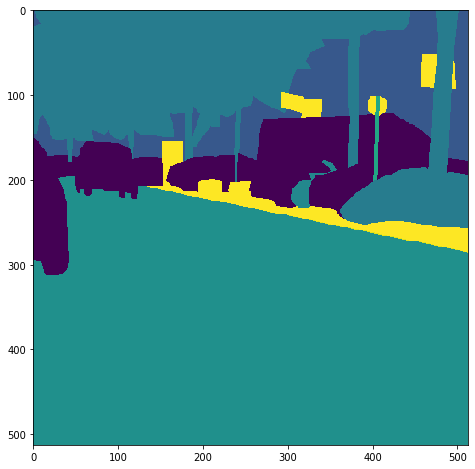

In [7]:
target_grid_image = make_grid(decode_seg_map_sequence(target[:1].numpy(), dataset=args.dataset), 3, normalize=False, range=(0, 255))
plt.figure(figsize = (12,8))
plt.imshow(target_grid_image[0])

In [8]:
# plt.figure(figsize = (12,8))
# plt.imshow(image[0][0])

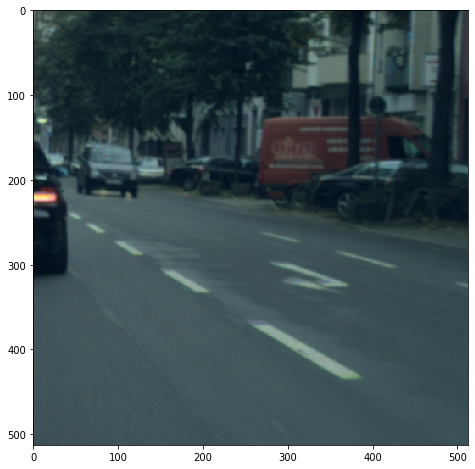

In [9]:
# plt.imshow(image[0].permute(1,2,0))
plt.figure(figsize = (12,8))
color_img = image[0].permute(1,2,0)
color_img = (color_img - color_img.min())/(color_img.max() - color_img.min())
plt.imshow(color_img)

## 各种采样

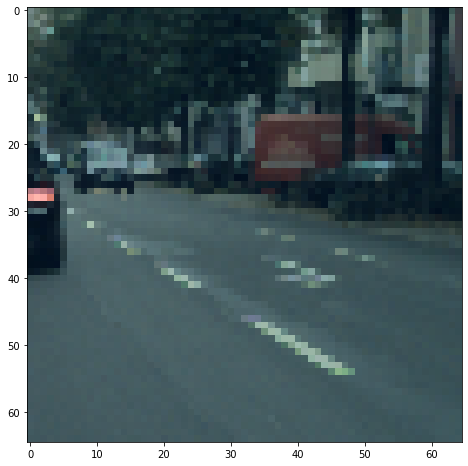

In [10]:
import torch.nn.functional as F

img_tensor_513 = F.interpolate(image, size=(65,65), mode='bilinear', align_corners=True)
plt.figure(figsize = (12,8))
color_img = img_tensor_513[0].permute(1,2,0)
color_img = (color_img - color_img.min())/(color_img.max() - color_img.min())
plt.imshow(color_img)

# 模型部分的处理和操作
- MSI-share-middle

In [11]:
from msisharemiddle import MultiScaleInitShareMiddle
model = MultiScaleInitShareMiddle(num_classes=num_class)

ModuleNotFoundError: No module named 'multiscaleinit'

In [12]:
checkpoint = torch.load('/home/xianr/TurboProjects/deeplab-msi/run/cityscapes/msi-share-middle/experiment_10/checkpoint.pth.tar')
model.load_state_dict(checkpoint['state_dict'])

In [13]:
output = model(image)

In [14]:
output.shape

torch.Size([4, 19, 513, 513])

In [15]:
torch.max(output[:3], 1)[1].shape

torch.Size([3, 513, 513])

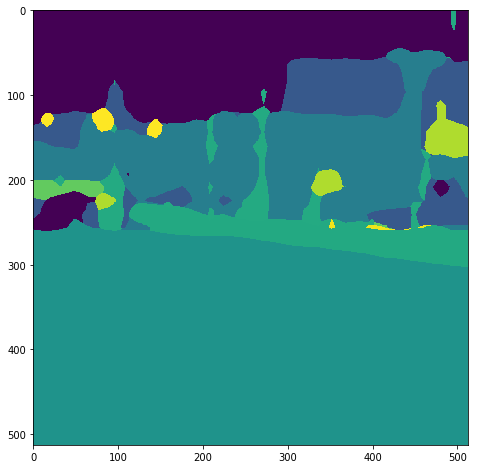

In [16]:
output_grid_image = make_grid(decode_seg_map_sequence(torch.max(output[:1], 1)[1].numpy(), dataset=args.dataset), 3, normalize=False, range=(0, 255))
plt.figure(figsize = (12,8))
plt.imshow(output_grid_image[0])
del output

# Look inside 模型内部推演

In [17]:
from multiscaleinit.build import build_init_multiscale_images

In [18]:
x513, x257, x129, x65, x33 = build_init_multiscale_images(image)

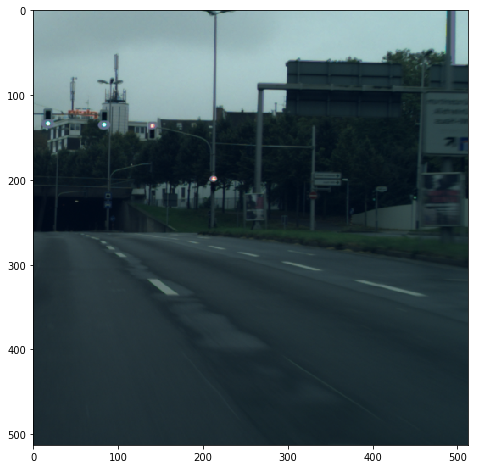

In [19]:
color_img = x513[0].permute(1,2,0)
color_img = (color_img - color_img.min())/(color_img.max() - color_img.min())
plt.figure(figsize = (12,8))
plt.imshow(color_img)

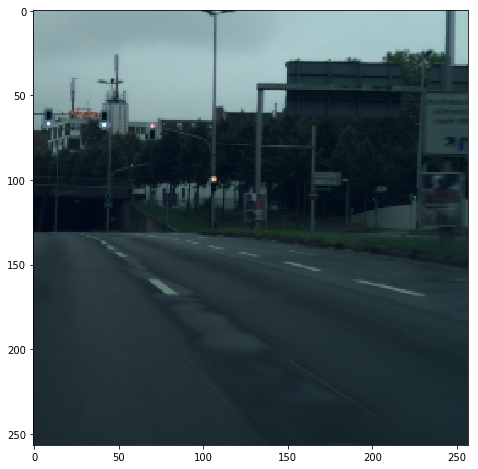

In [20]:
color_img = x257[0].permute(1,2,0)
color_img = (color_img - color_img.min())/(color_img.max() - color_img.min())
plt.figure(figsize = (12,8))
plt.imshow(color_img)

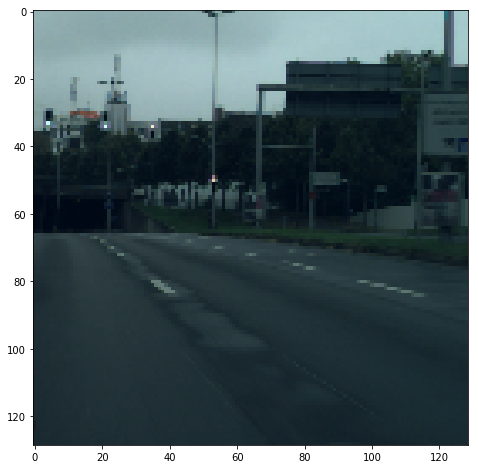

In [21]:
color_img = x129[0].permute(1,2,0)
color_img = (color_img - color_img.min())/(color_img.max() - color_img.min())
plt.figure(figsize = (12,8))
plt.imshow(color_img)

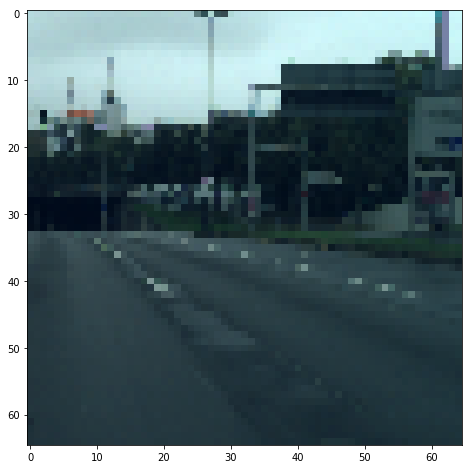

In [22]:
color_img = x65[0].permute(1,2,0)
color_img = (color_img - color_img.min())/(color_img.max() - color_img.min())
plt.figure(figsize = (12,8))
plt.imshow(color_img)

In [23]:
bt_size, chn_size, _, __ = x513.shape
x513 = x513.view(bt_size*chn_size, 1, x513.shape[2], x513.shape[3])
x257 = x257.view(bt_size*chn_size, 1, x257.shape[2], x257.shape[3])
x129 = x129.view(bt_size*chn_size, 1, x129.shape[2], x129.shape[3])
x65 = x65.view(bt_size*chn_size, 1, x65.shape[2], x65.shape[3])

In [24]:
line_x513 = model.line_conv(x513)
sobel_x513 = model.sobel_conv(x513)
line_x257 = model.line_conv(x257)
sobel_x257 = model.sobel_conv(x257)
line_x129 = model.line_conv(x129)
sobel_x129 = model.sobel_conv(x129)
line_x65 = model.line_conv(x65)
sobel_x65 = model.sobel_conv(x65)
# 整回原来的样子, 以为之前为了方便, 把3个channel当batch看待了
line_x513 = line_x513.view(bt_size, chn_size*line_x513.shape[1], line_x513.shape[2], line_x513.shape[3])
sobel_x513 = line_x513.view(bt_size, chn_size*sobel_x513.shape[1], sobel_x513.shape[2], sobel_x513.shape[3])
line_x257 = line_x257.view(bt_size, chn_size*line_x257.shape[1], line_x257.shape[2], line_x257.shape[3])
sobel_x257 = sobel_x257.view(bt_size, chn_size*sobel_x257.shape[1], sobel_x257.shape[2], sobel_x257.shape[3])
line_x129 = line_x129.view(bt_size, chn_size*line_x129.shape[1], line_x129.shape[2], line_x129.shape[3])
sobel_x129 = sobel_x129.view(bt_size, chn_size*sobel_x129.shape[1], sobel_x129.shape[2], sobel_x129.shape[3])
line_x65 = line_x65.view(bt_size, chn_size*line_x65.shape[1], line_x65.shape[2], line_x65.shape[3])
sobel_x65 = sobel_x65.view(bt_size, chn_size*sobel_x65.shape[1], sobel_x65.shape[2], sobel_x65.shape[3])

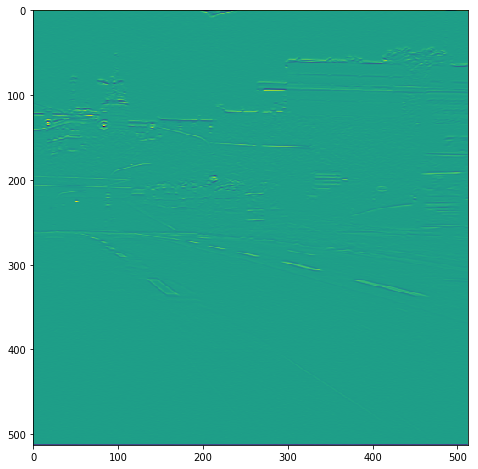

In [25]:
plt.figure(figsize = (12,8))
plt.imshow(sobel_x513[0][0])

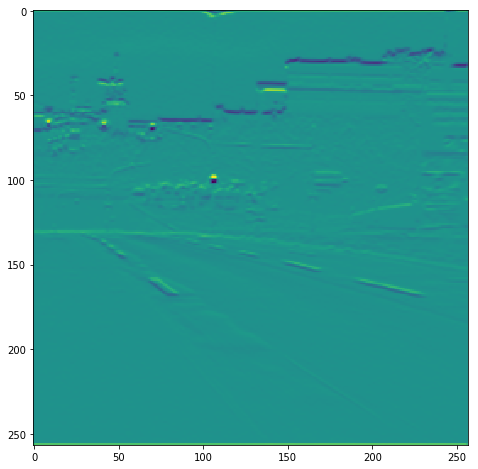

In [26]:
plt.figure(figsize = (12,8))
plt.imshow(sobel_x257[0][0])

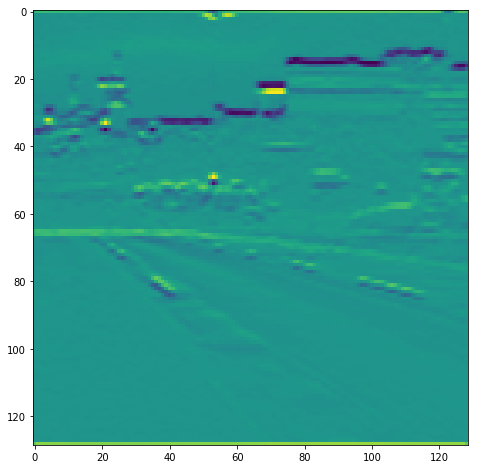

In [27]:
plt.figure(figsize = (12,8))
plt.imshow(sobel_x129[0][0])

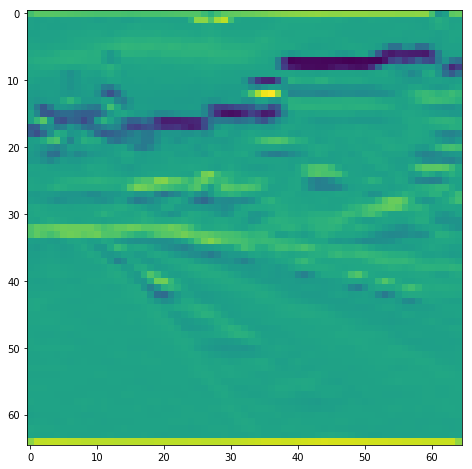

In [28]:
plt.figure(figsize = (12,8))
plt.imshow(sobel_x65[0][0])

In [34]:
x513 = x513.view(bt_size, chn_size, x513.shape[2], x513.shape[3])
x257 = x257.view(bt_size, chn_size, x257.shape[2], x257.shape[3])
x129 = x129.view(bt_size, chn_size, x129.shape[2], x129.shape[3])
x65 = x65.view(bt_size, chn_size, x65.shape[2], x65.shape[3])

x513 = torch.cat((x513, line_x513, sobel_x513), 1)
x257 = torch.cat((x257, line_x257, sobel_x257), 1)
x129 = torch.cat((x129, line_x129, sobel_x129), 1)
x65 = torch.cat((x65, line_x65, sobel_x65), 1)

mix_x513 = model.conv513_mix(x513)
mix_x257 = model.conv257_mix(x257)
mix_x129 = model.conv513_mix(x129)
mix_x65 = model.conv65_mix(x65)

mix_x513 = model.bn_mix_513(mix_x513)
mix_x257 = model.bn_mix_257(mix_x257)
mix_x129 = model.bn_mix_129(mix_x129)
mix_x65 = model.bn_mix_65(mix_x65)
mix_x513 = F.relu(mix_x513)
mix_x257 = F.relu(mix_x257)
mix_x129 = F.relu(mix_x129)
mix_x65 = F.relu(mix_x65)

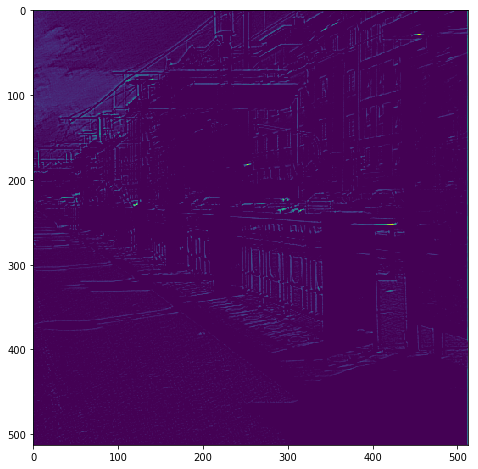

In [42]:
resize_513 = F.interpolate(mix_x513, size=(513,513), mode='bilinear', align_corners=True)
plt.figure(figsize = (12,8))
plt.imshow(resize_513[0][0].detach())

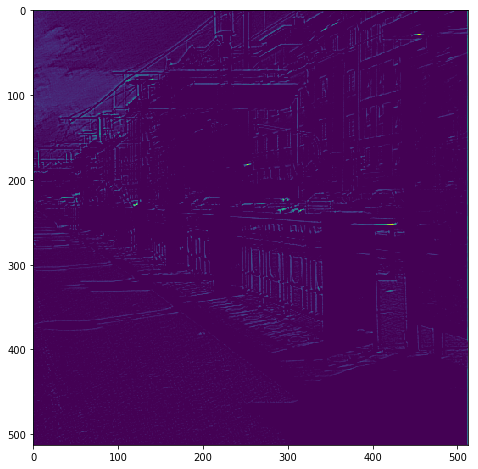

In [38]:
plt.figure(figsize = (12,8))
plt.imshow(mix_x513[0][0].detach())

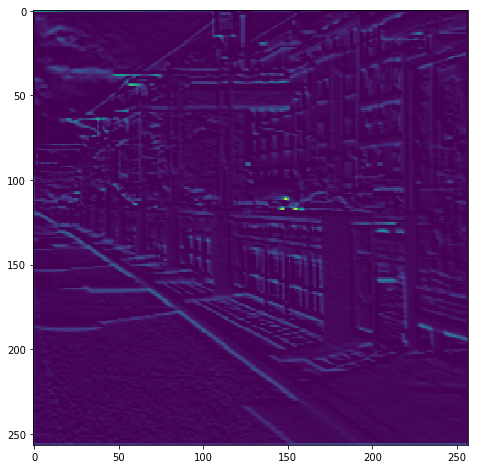

In [39]:
plt.figure(figsize = (12,8))
plt.imshow(mix_x257[0][0].detach())

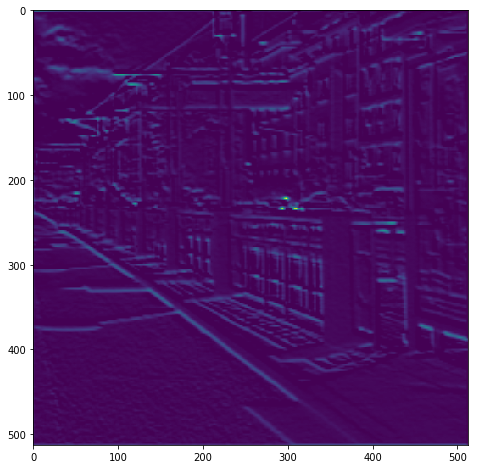

In [43]:
resize_513 = F.interpolate(mix_x257, size=(513,513), mode='bilinear', align_corners=True)
plt.figure(figsize = (12,8))
plt.imshow(resize_513[0][0].detach())

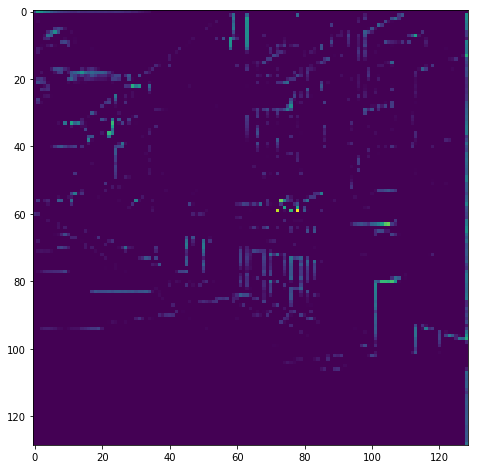

In [40]:
plt.figure(figsize = (12,8))
plt.imshow(mix_x129[0][0].detach())

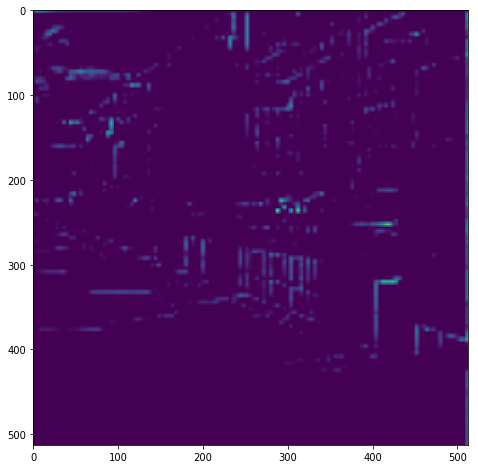

In [44]:
resize_513 = F.interpolate(mix_x129, size=(513,513), mode='bilinear', align_corners=True)
plt.figure(figsize = (12,8))
plt.imshow(resize_513[0][0].detach())

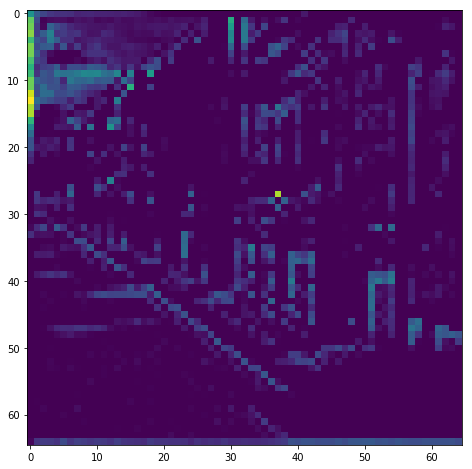

In [41]:
plt.figure(figsize = (12,8))
plt.imshow(mix_x65[0][0].detach())

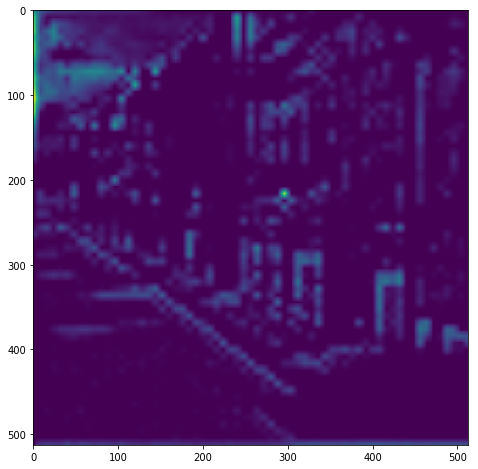

In [45]:
resize_513 = F.interpolate(mix_x65, size=(513,513), mode='bilinear', align_corners=True)
plt.figure(figsize = (12,8))
plt.imshow(resize_513[0][0].detach())

# 几次卷积的信息提取 利用7*7卷积总结信息

In [2]:
x513_257 = model.share_conv1(mix_x513)

NameError: name 'model' is not defined